# MCMC Methods

In [2]:
%matplotlib inline

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
from functools import partial
from jax.scipy.special import logsumexp

# Mixture of Gaussians (MOG)

The first target density to design our MCMC algorithms is the mixture of Gaussians
$$p(x) = \sum_i w_i\mathcal{N}(x|\mu_i,\sigma_i^2)\,.$$
In practice, we always implement $\log p(x)$ instead of the density because the gradient of density vanishes very quickly unlike gradients of the log-density.

In [3]:
def log_prob_mog(x, means, covs, weights):
  diff = x[:, jnp.newaxis, :] - means[jnp.newaxis, ...]  # Shape: (batch_size, n_modes, dim)
  sol = jnp.linalg.solve(covs[jnp.newaxis, ...], diff[..., jnp.newaxis])  # Shape: (batch_size, n_modes, dim, 1)
  log_prob = -0.5 * jnp.squeeze(jnp.matmul(diff[..., jnp.newaxis, :], sol), axis=-1).squeeze(-1)  # Shape: (batch_size, n_modes)
  _, logdet_cov = jnp.linalg.slogdet(covs)
  log_prob -= 0.5 * (x.shape[-1] * jnp.log(2. * jnp.pi) + logdet_cov)[jnp.newaxis, :]
  log_prob += jnp.log(weights / weights.sum())[None, :]
  return logsumexp(log_prob, axis=1)

radius = 3.0
scale = 0.1
means = jnp.stack([
      radius * jnp.array([
          jnp.sin(i * jnp.pi / 4),
          jnp.cos(i * jnp.pi / 4)
      ]) for i in range(8)
  ])
covs = scale * jnp.stack([jnp.eye(2)] * 8)
weights=(1/8)*jnp.ones(8,)
logp = lambda x: log_prob_mog(x, means, covs, weights)

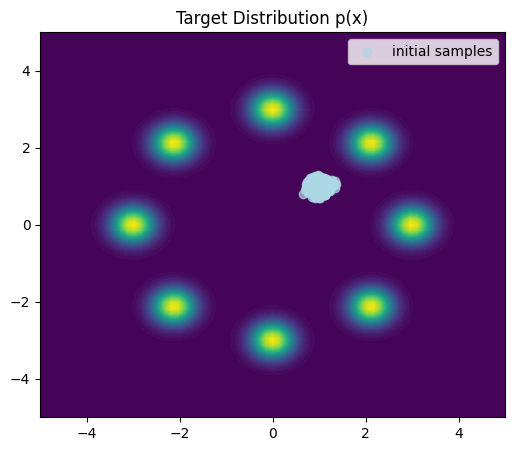

In [4]:
def plot_density():
  x,y = jnp.linspace(-5,5,75), jnp.linspace(-5,5,75)
  x,y = jnp.meshgrid(x,y)
  grid = jnp.stack([x, y]).transpose((1,2,0)).reshape((-1,2))
  plt.xlim(-5,5)
  plt.ylim(-5,5)
  plt.contourf(x,y,jnp.exp(logp(grid)).reshape(x.shape), levels=50)
  
plt.figure(figsize=(6, 5))
key = jax.random.PRNGKey(1)
key, init_key = jax.random.split(key)
n_samples = 1000
x_init = 1+0.1*jax.random.normal(init_key, shape=(n_samples, 2))
  
plot_density()
plt.scatter(x_init[:,0], x_init[:,1], color="lightblue", alpha=0.7, label='initial samples')
plt.title("Target Distribution p(x)")
plt.legend()
plt.show()

## Random Walk Metropolis Hastings (RWMH) (5 points)

Implement the Metropolis-Hastings algorithm with Random Walk proposal. Recall that the Metropolis-Hastings algorithm is
1. generate proposal $x' \sim q(x'|x)$,
2. evaluate the acceptance probability $$P_{\text{accept}} = \min\bigg\{1,\frac{p(x')q(x|x')}{p(x)q(x'|x)}\bigg\}$$,
3. set next sample to $x'$ with probability $P_{\text{accept}}$ or to $x$ with probability $1-P_{\text{accept}}$.

Random Walk proposal in our case is simply
$$q(x'|x) = \mathcal{N}(x'|x,\tau)\,,$$
where $\tau$ is the step-size hyperparameter.

The function `RWMH` implements one step of Random Walk Metropolis Hastings for many parallel chains. It outputs next samples and the Acceptance Rate, which is the average number of the accepted samples across all the chains.

In [182]:
@partial(jax.jit, static_argnums=1)
def RWMH(key, logp, x, tau):
    key, sample_key = jax.random.split(key)
    eps = jax.random.normal(sample_key, shape=(n_samples, 2))
    x_prime = x + eps*jnp.sqrt(tau)
    log_px = logp(x)
    log_px_prime = logp(x_prime)
    log_accept_ratio = log_px_prime - log_px
    accept_prob = jnp.exp(jnp.minimum(log_accept_ratio, 0))

    key, accept_key = jax.random.split(key)
    uniform = jax.random.uniform(accept_key, shape=(n_samples,))
    accept = uniform < accept_prob

    x_next = jnp.where(accept[:, None], x_prime, x)
    AR = jnp.mean(accept)
    
    return x_next, AR

In [183]:
tau = 0.1
n_iter = 1000
save_every = n_iter//5

x = x_init.copy()
xs, ar_plot = [], []
for i in trange(n_iter):
    key, loc_key = jax.random.split(key)
    x, AR = RWMH(loc_key, logp, x, tau)
    ar_plot.append(AR)
    
    if (i % save_every == 0) and i != 0:
        xs.append(x)

xs.append(x)
xs = jnp.stack(xs)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1548.64it/s]


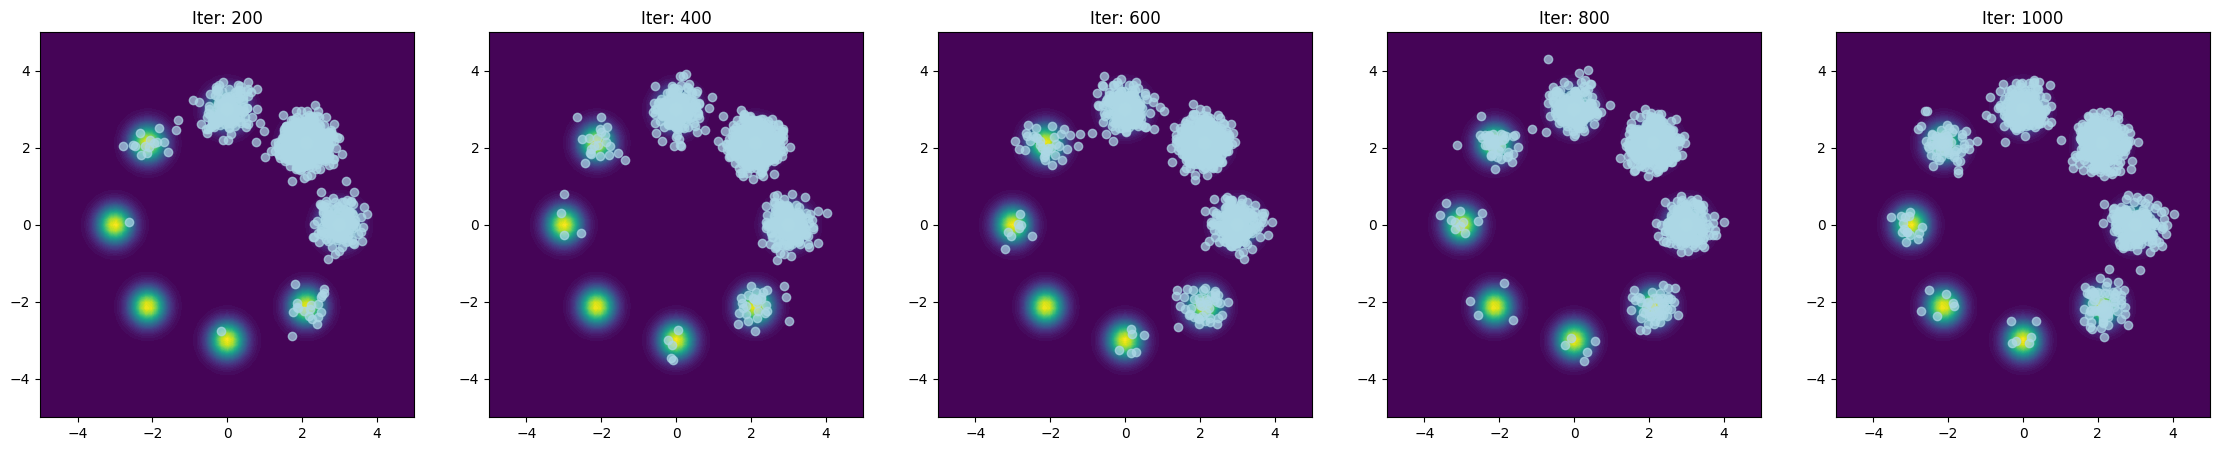

In [184]:
plt.figure(figsize=(28, 5))
for i in range(int(n_iter/save_every)):
    plt.subplot(1, 5, i + 1)
    plot_density()
    plt.scatter(xs[i, :, 0], xs[i, :, 1], color="lightblue", alpha=0.7)
    plt.title(f"Iter: {(i + 1)* save_every}")
plt.show()

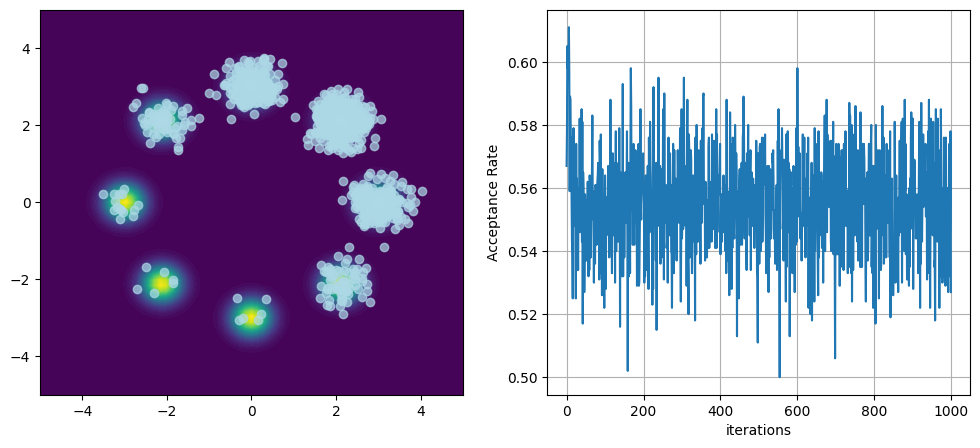

In [185]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_density()
plt.scatter(x[:,0], x[:,1], color="lightblue", alpha=0.7)
plt.subplot(122)
plt.xlabel('iterations')
plt.ylabel('Acceptance Rate')
plt.plot(ar_plot)
plt.grid()
plt.show()

## Analyse the plots 
- How does the distribution of samples look like? Does it match the target density?
- What happens with the Acceptance Rate?

## Adaptive Step Size (2 points)

Based on the estimated Acceptance Rate, at every iteration, adjust the step size to keep the acceptance rate in the interval $[0.5,0.55]$. There are multiple ways you can adjust the step size and there is no right one. Try different ways, look at the plots, converge on the solution.

In [277]:
tau = 0.1
n_iter = 1000
save_every = n_iter//5

x = x_init.copy()
xs, ar_plot, tau_plot = [], [], []
for i in trange(n_iter):
    key, loc_key = jax.random.split(key)
    x, AR = RWMH(loc_key, logp, x, tau)
    if AR < 0.5:
        tau -= 0.1*(0.5-AR)
    if AR > 0.55:
        tau += 0.1*(AR-0.55)
    ar_plot.append(AR)
    tau_plot.append(tau)
    
    if (i % save_every == 0) and i != 0:
        xs.append(x)

xs.append(x)
xs = jnp.stack(xs)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3607.02it/s]


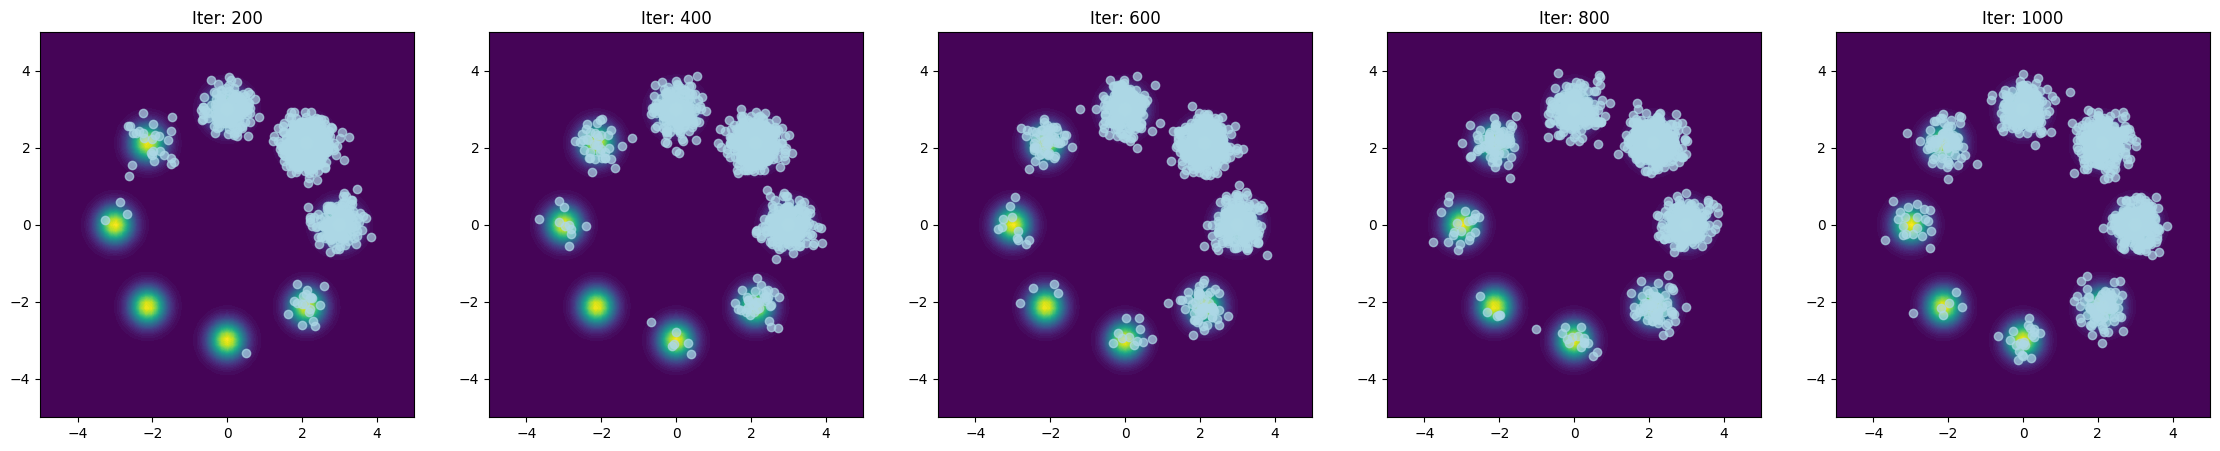

In [278]:
plt.figure(figsize=(28, 5))
for i in range(int(n_iter/save_every)):
    plt.subplot(1, 5, i + 1)
    plot_density()
    plt.scatter(xs[i, :, 0], xs[i, :, 1], color="lightblue", alpha=0.7)
    plt.title(f"Iter: {(i + 1)* save_every}")
plt.show()

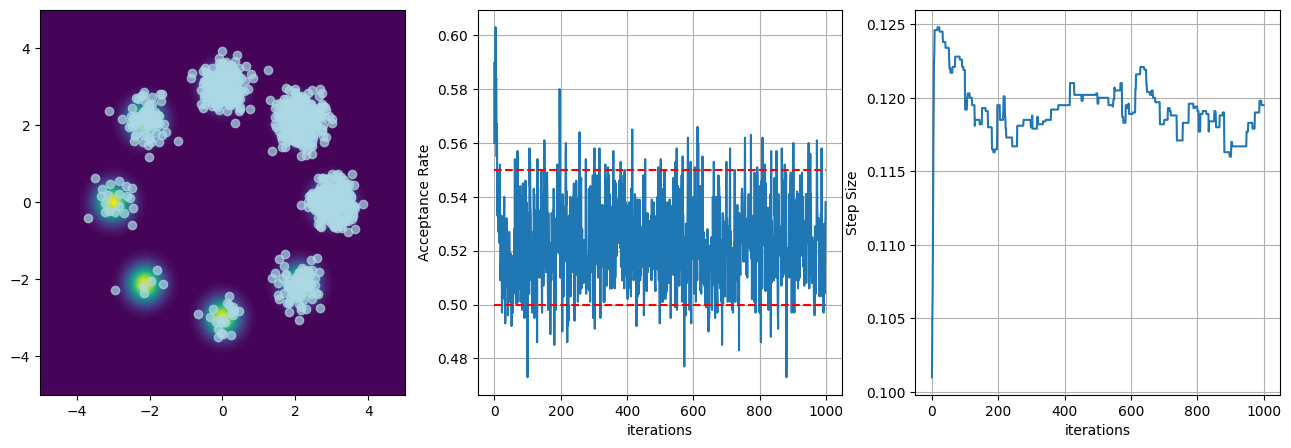

In [279]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plot_density()
plt.scatter(x[:,0], x[:,1], color="lightblue", alpha=0.7)
plt.subplot(132)
plt.xlabel('iterations')
plt.ylabel('Acceptance Rate')
plt.plot(ar_plot)
plt.hlines([0.5,0.55], 0, 1000, "red", "dashed")
plt.grid()
plt.subplot(133)
plt.xlabel('iterations')
plt.ylabel('Step Size')
plt.plot(tau_plot)
plt.grid()
plt.show()

## Conclusion
- Argue for your choice of the adaptive step size technique. Does it keep the acceptance rate within the target interval?
- Does keeping the acceptance rate within the target interval helps sampling? What's the intuition for this? Isn't it better to always accept samples?

## Unadjusted-Langevin Algorithm (ULA) (3 points)

Implement the Langevin Dynamics, i.e. Euler discretization of the following SDE
$$dx = \nabla_x \log p(x) dt + \sqrt{2}dW_t\,,$$ 
where $dt$ is the step size, and $dW_t$ is the standard Wiener process. The time-discretized scheme is
$$x_{t+\tau} = x_t + \nabla_x \log p(x_t) \tau + \sqrt{2\tau}\varepsilon \;\;\varepsilon \sim \mathcal{N}(0,1)\,.$$

In [280]:
@partial(jax.jit, static_argnums=1)
def ULA(key, logp, x, tau):
    key, sample_key = jax.random.split(key)
    eps = jax.random.normal(sample_key, shape=(n_samples, 2))
    grad_logp = jax.vmap(jax.grad(lambda xi: logp(xi.reshape(1,-1))[0]))

    x_next = x + grad_logp(x)*tau + jnp.sqrt(2*tau)*eps
    return x_next, None

In [281]:
tau = 0.1
n_iter = 1000
save_every = n_iter//5

x = x_init.copy()
xs, ar_plot = [], []
for i in trange(n_iter):
    key, loc_key = jax.random.split(key)
    x, AR = ULA(loc_key, logp, x, tau)
    ar_plot.append(AR)
    
    if (i % save_every == 0) and i != 0:
        xs.append(x)

xs.append(x)
xs = jnp.stack(xs)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1942.82it/s]


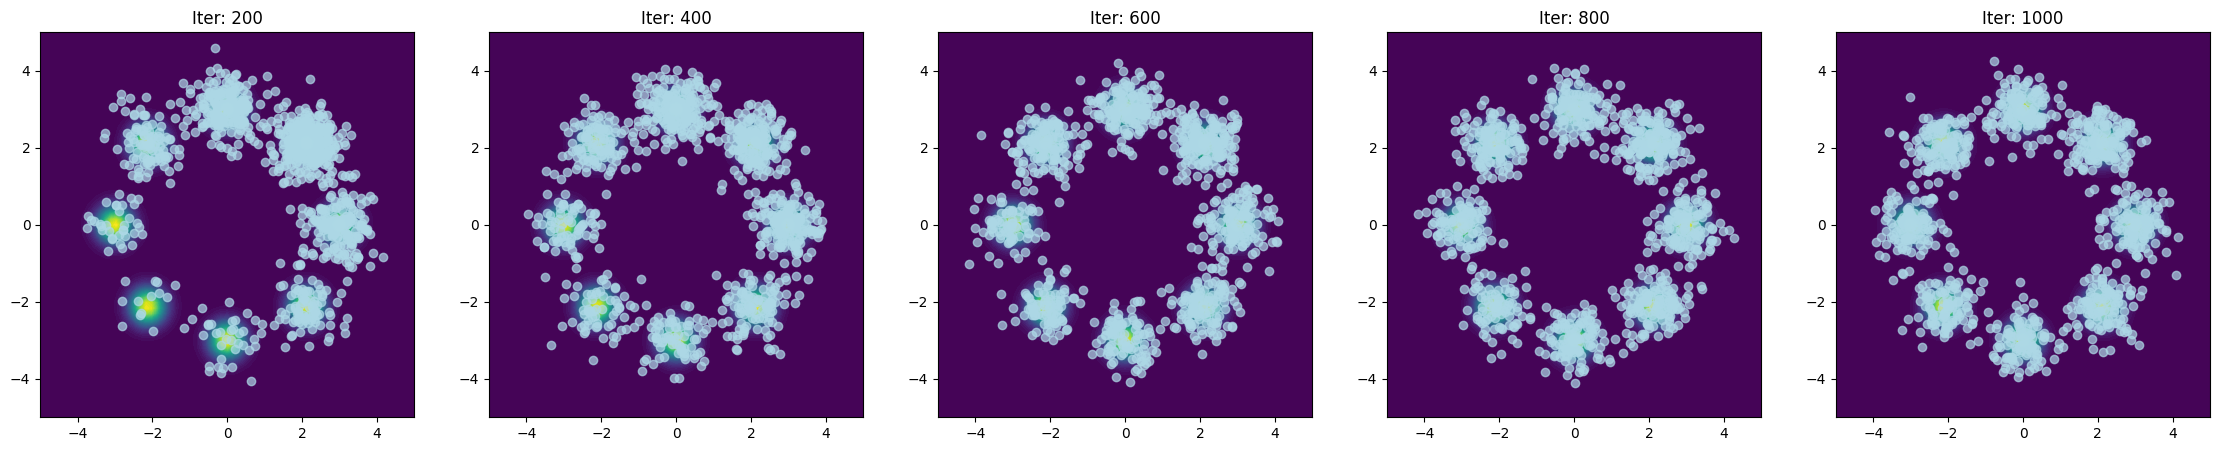

In [282]:
plt.figure(figsize=(28, 5))
for i in range(int(n_iter/save_every)):
    plt.subplot(1, 5, i + 1)
    plot_density()
    plt.scatter(xs[i, :, 0], xs[i, :, 1], color="lightblue", alpha=0.7)
    plt.title(f"Iter: {(i + 1)* save_every}")
plt.show()

## Conclusion
- Does ULA sample from the target distribution, i.e. does the distribution of samples match the target density?
- How does it compare with RWMH? What are the main differences with RWMH?

### Metropolis-Adjusted Langevin Algorithm (MALA) (5 points)

Implement the Metropolish Hastings algorithm where for the proposal we use the Langevin Dynamics, i.e.
$$q(x'|x) = \mathcal{N}(x'|x + \nabla_x \log p(x) \tau, 2\tau)\,.$$ 
Use the adaptive step size to keep the acceptance rate in the interval $[0.5,0.55]$ as before.

In [404]:
@partial(jax.jit, static_argnums=1)
def MALA(key, logp, x, tau):
    key, sample_key = jax.random.split(key)
    eps = jax.random.normal(sample_key, shape=(n_samples, 2))
    grad_logp = jax.vmap(jax.grad(lambda xi: logp(xi.reshape(1,-1))[0]))
    x_prime = (x + grad_logp(x)*tau) + eps*jnp.sqrt(2*tau)
    log_qx_xprime = -jnp.sum((x - (x_prime + grad_logp(x_prime)*tau))**2, axis=1)/(4*tau)
    log_qxprime_x = -jnp.sum((x_prime - (x + grad_logp(x)*tau))**2, axis=1)/(4*tau)
    log_px = logp(x)
    log_px_prime = logp(x_prime)
    log_accept_ratio = (log_px_prime+log_qx_xprime) - (log_px+log_qxprime_x)
    accept_prob = jnp.exp(jnp.minimum(log_accept_ratio, 0))

    key, accept_key = jax.random.split(key)
    uniform = jax.random.uniform(accept_key, shape=(n_samples,))
    accept = uniform < accept_prob

    x_next = jnp.where(accept[:, None], x_prime, x)
    AR = jnp.mean(accept)
    return x_next, AR

In [405]:
tau = 0.1
n_iter = 1000
save_every = n_iter//5

x = x_init.copy()
xs, ar_plot, tau_plot = [], [], []
for i in trange(n_iter):
    key, loc_key = jax.random.split(key)
    x, AR = MALA(loc_key, logp, x, tau)
    if AR < 0.5:
        tau -= 0.05*(0.5-AR)
    if AR > 0.55:
        tau += 0.05*(AR-0.55)
    ar_plot.append(AR)
    tau_plot.append(tau)
    
    if (i % save_every == 0) and i != 0:
        xs.append(x)

xs.append(x)
xs = jnp.stack(xs)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 485.32it/s]


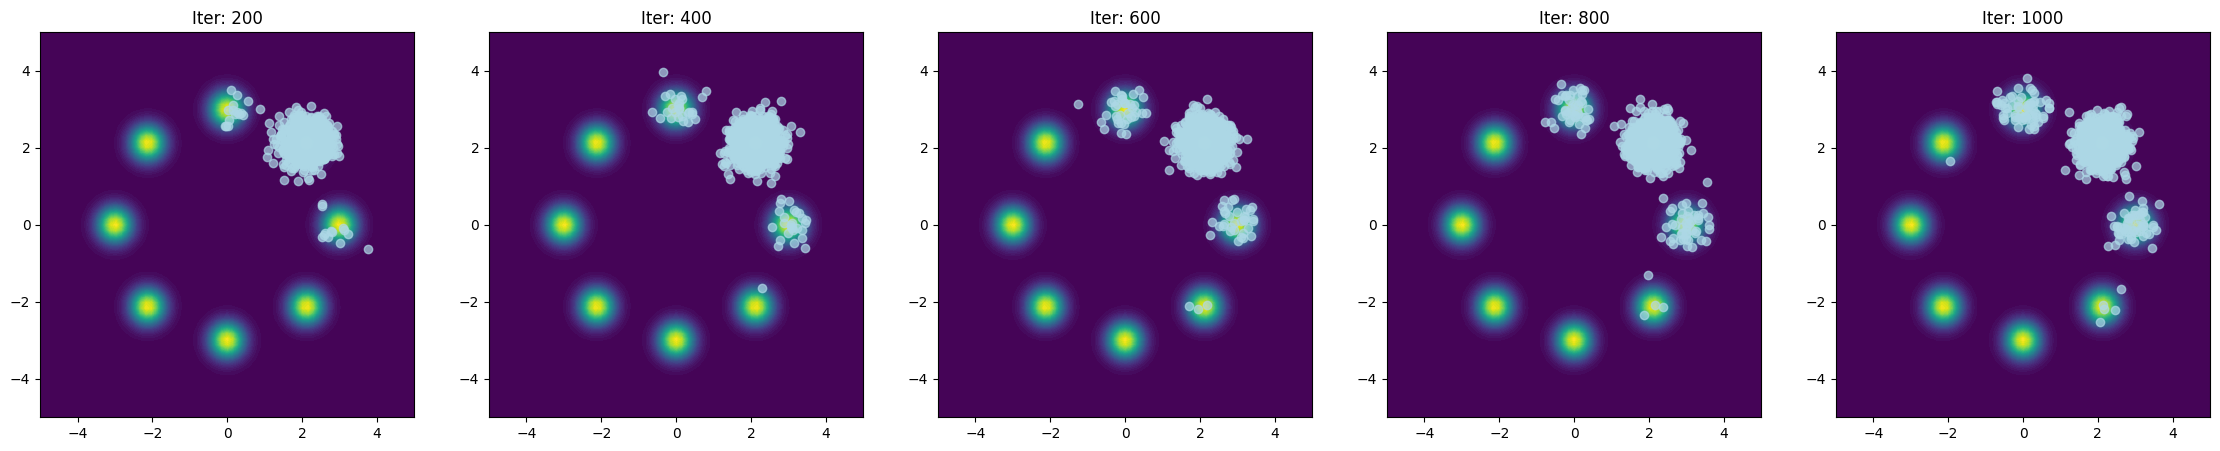

In [406]:
plt.figure(figsize=(28, 5))
for i in range(int(n_iter/save_every)):
    plt.subplot(1, 5, i + 1)
    plot_density()
    plt.scatter(xs[i, :, 0], xs[i, :, 1], color="lightblue", alpha=0.7)
    plt.title(f"Iter: {(i + 1)* save_every}")
plt.show()

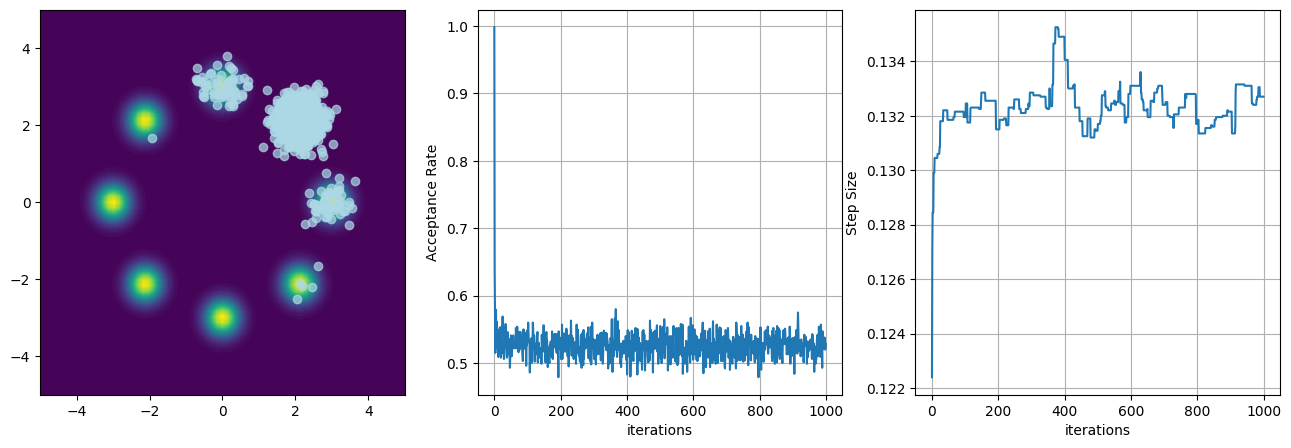

In [407]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plot_density()
plt.scatter(x[:,0], x[:,1], color="lightblue", alpha=0.7)
plt.subplot(132)
plt.xlabel('iterations')
plt.ylabel('Acceptance Rate')
plt.plot(ar_plot)
plt.grid()
plt.subplot(133)
plt.xlabel('iterations')
plt.ylabel('Step Size')
plt.plot(tau_plot)
plt.grid()
plt.show()

## Conclusion
- How does it perform compared to ULA and RWMH?
- Does your step size adjustment keep the acceptance rate within the target interval?
- Which algorithm out of the three implemented would you use for this task? Maybe a combination of the algorithms?

## Bayesian Logistic Regression (7 points)

Finally, use the implemented MCMC algorithms to sample from the posterior distribution of the Bayesian Logistic Regression. Namely, consider the following probabilistic model. The likelihood is
$$p(y| x,\theta) = \sigma(w^Tx + b)^{y=1}(1-\sigma(w^Tx + b))^{y=0}\,,$$
where the vector of parameters $\theta = (w,b)$. The prior is
$$p(\theta) = p(w) = \mathcal{N}(w|0,1)\,.$$
Implement the posterior distribution log-density
$$\log p(\theta|D) = \sum_i \log p(y_i|x_i,\theta) + \log p(\theta)\,.$$
Implement the evaluation of accuracy for the predictive distribution
$$p(y|x) = \mathbb{E}_{p(\theta|D)}p(y|x,\theta) \approx \frac{1}{n}\sum_{i=1}^n p(y|x,\theta_i)\,, \theta_i \sim p(\theta|D)\,.$$

Beware of numerical instabilities cause by zeros in the logarithms!

In [ ]:
data = np.load('data.npy').squeeze()
labels = np.load('labels.npy').squeeze()
dm = np.mean(data, axis=0)
ds = np.std(data, axis=0)
data = (data - dm) / ds
num_features = data.shape[1]  

def logp(theta):
  # YOUR CODE HERE

def get_accuracy(theta):
  # YOUR CODE HERE

key, init_key = jax.random.split(key)
theta_init = jax.random.normal(init_key, (n_samples,num_features+1))

In [ ]:
# these ground true values were estimated using a very long markov chain
gt_mean = np.array([-0.13996868,  0.71390106,  0.69571619,  0.43944853,  0.36997702, -0.27319424,
                    0.31730518, -0.49617367,  0.40516419, 0.4312388,   0.26531786, 1.10337417,
                    0.70054367, -0.25684964])
gt_std = np.array([0.22915648,  0.24545612,  0.20457998,  0.20270157,  0.21040644,  0.20094482,
                   0.19749419,  0.24134014,  0.20230987,  0.25595334,  0.23709087,  0.24735325,
                   0.20701178,  0.19771984])

def run_MCMC(key, algorithm, adaptive_AR=True):
  tau = 0.02
  n_iter = 1000
  save_every = 5

  theta = theta_init.copy()
  thetas, ar_plot, tau_plot = [], [], []
  for i in trange(n_iter):
      key, loc_key = jax.random.split(key)
      theta, AR = algorithm(loc_key, logp, theta, tau)
      if adaptive_AR:
        # YOUR CODE HERE
      ar_plot.append(AR)
      tau_plot.append(tau)
      
      if (i % save_every == 0) and i != 0:
          thetas.append(theta)

  thetas.append(theta)
  thetas = jnp.stack(thetas)
  return thetas

collecting samples using different algorithms

In [ ]:
key, *loc_keys = jax.random.split(key, 4)
thetas_rwmh = run_MCMC(loc_keys[0], RWMH)
thetas_ula = run_MCMC(loc_keys[1], ULA, False)
thetas_mala = run_MCMC(loc_keys[2], MALA)

### Analysis of the results

In [ ]:
@jax.jit
def get_metrics(samples):
  err_mean = ((samples.mean(0)-gt_mean)**2).sum()
  err_std = ((samples.std(0)-gt_std)**2).sum()
  acc = get_accuracy(samples)
  return err_mean, err_std, acc

def evaluate_samples(thetas):
  err_plot_mean, err_plot_std, acc_plot = [], [], []
  for i in range(1,len(thetas)+1):
    err_mean, err_std, acc = get_metrics(thetas[:i].reshape(-1,thetas.shape[-1]))
    err_plot_mean.append(err_mean)
    err_plot_std.append(err_std)
    acc_plot.append(acc)
  return {'mean': err_plot_mean, 'std': err_plot_std, 'acc': acc_plot}

plots_rwmh = evaluate_samples(thetas_rwmh)
plots_ula = evaluate_samples(thetas_ula)
plots_mala = evaluate_samples(thetas_mala)

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.xlabel('iterations')
plt.ylabel('Error of the Estimated Mean')
plt.xscale('log')
plt.yscale('log')
plt.plot(10**3*np.arange(1,len(thetas_rwmh)+1), plots_rwmh['mean'], label='RWMH')
plt.plot(10**3*np.arange(1,len(thetas_ula)+1), plots_ula['mean'], label='ULA')
plt.plot(10**3*np.arange(1,len(thetas_mala)+1), plots_mala['mean'], label='MALA')
plt.legend()
plt.grid()
plt.subplot(132)
plt.xlabel('iterations')
plt.ylabel('Error of the Estimated Standard Deviation')
plt.xscale('log')
plt.yscale('log')
plt.plot(10**3*np.arange(1,len(thetas_rwmh)+1), plots_rwmh['std'], label='RWMH')
plt.plot(10**3*np.arange(1,len(thetas_ula)+1), plots_ula['std'], label='ULA')
plt.plot(10**3*np.arange(1,len(thetas_mala)+1), plots_mala['std'], label='MALA')
plt.legend()
plt.grid()
plt.subplot(133)
plt.xlabel('iterations')
plt.ylabel('Classification Accuracy')
plt.xscale('log')
plt.plot(10**3*np.arange(1,len(thetas_rwmh)+1), plots_rwmh['acc'], label='RWMH')
plt.plot(10**3*np.arange(1,len(thetas_ula)+1), plots_ula['acc'], label='ULA')
plt.plot(10**3*np.arange(1,len(thetas_mala)+1), plots_mala['acc'], label='MALA')
plt.legend()
plt.grid()
plt.show()

## Conclusion
- Which algorithm performs the best for the estimation of the ground true mean and std of the posterior distribution? What's the intuition for this?
- Which algorithm performs the best for predicting the labels (in terms of the accuracy)? What's the intuition for this?
- Did your ranking of the algorithms changed compared to the Mixture of Gaussians? Why?
- What are you going to do if you get a "black box" density?